In [4]:
pip install matplotlib

  Using cached matplotlib-3.9.4-cp39-cp39-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp39-cp39-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
Using cached matplotlib-3.9.4-cp39-cp39-win_amd64.whl (7.8 MB)
Using cached contourpy-1.3.0-cp39-cp39-win_amd64.whl (211 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   -------------- ------------------------- 0.8/2.2 MB 3.1 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 4.6 MB/s eta 0:00:00
Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
Using cached kiwisolver-1.4.7-cp39-cp39-wi

In [6]:
pip install opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-image

  Using cached scikit_image-0.24.0-cp39-cp39-win_amd64.whl.metadata (14 kB)
  Using cached scipy-1.13.1-cp39-cp39-win_amd64.whl.metadata (60 kB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached tifffile-2024.8.30-py3-none-any.whl.metadata (31 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached scikit_image-0.24.0-cp39-cp39-win_amd64.whl (12.9 MB)
Using cached imageio-2.37.0-py3-none-any.whl (315 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)
Using cached scipy-1.13.1-cp39-cp39-win_amd64.whl (46.2 MB)
Using cached tifffile-2024.8.30-py3-none-any.whl (227 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
#1: Imports
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.ops import DeformConv2d
from torchmetrics.functional import peak_signal_noise_ratio, structural_similarity_index_measure
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from skimage.feature import canny
import tqdm

print("All imports successful!")
print("PyTorch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("CUDA:", torch.cuda.is_available())

All imports successful!
PyTorch: 1.12.1+cu113
Torchvision: 0.13.1+cu113
CUDA: True


In [2]:
#2: Edge Map Function
def get_edge_map(image):
    # Handle single ([C, H, W]) or batched ([B, C, H, W]) tensors
    image = image.detach().cpu()
    is_batched = len(image.shape) == 4
    
    if is_batched:
        batch_size = image.shape[0]
        edge_maps = []
        for i in range(batch_size):
            img_np = image[i].numpy().transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]
            img_np = (img_np + 1) / 2  # [-1, 1] to [0, 1]
            edges = canny(img_np.mean(axis=2), sigma=2)
            edge_maps.append(torch.tensor(edges, dtype=torch.float32))
        return torch.stack(edge_maps, dim=0).unsqueeze(1).to(image.device)  # [B, 1, H, W]
    else:
        # Single image case
        img_np = image.numpy().transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]
        img_np = (img_np + 1) / 2  # [-1, 1] to [0, 1]
        edges = canny(img_np.mean(axis=2), sigma=2)
        return torch.tensor(edges, dtype=torch.float32).unsqueeze(0).to(image.device)  # [1, H, W]

In [3]:
#3: Enhanced Generator

class DeformableBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.offset_conv = nn.Conv2d(in_channels, 2 * 3 * 3, 3, padding=1)
        self.deform_conv = DeformConv2d(in_channels, out_channels, 3, padding=1)
        self.norm = nn.GroupNorm(16, out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        offset = self.offset_conv(x)
        x = self.deform_conv(x, offset)
        x = self.norm(x)
        x = self.relu(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(16, channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(16, channels)
    
    def forward(self, x):
        residual = x
        x = F.leaky_relu(self.norm1(self.conv1(x)), 0.2)
        x = self.norm2(self.conv2(x))
        return x + residual

class AttentionModule(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        attn = self.sigmoid(self.conv(x))
        return x * attn

class EnhancedGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: Downsample to 64x64
        self.enc1 = nn.Conv2d(4, 64, 4, 2, 1)  # 256x256 -> 128x128
        self.enc2 = DeformableBlock(64, 128)    # 128x128
        self.enc3 = nn.Conv2d(128, 256, 4, 2, 1)  # 128x128 -> 64x64
        
        # Residual blocks at bottleneck
        self.res_blocks = nn.ModuleList([ResidualBlock(256) for _ in range(6)])
        self.attn = AttentionModule(256)
        
        # Decoder: Upsample back to 256x256
        self.dec3 = nn.ConvTranspose2d(256, 128, 4, 2, 1)  # 64x64 -> 128x128
        self.dec2 = DeformableBlock(128, 64)               # 128x128
        self.dec1 = nn.ConvTranspose2d(64, 3, 4, 2, 1)    # 128x128 -> 256x256
        
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        e1 = F.leaky_relu(self.enc1(x), 0.2)
        e2 = self.enc2(e1)
        e3 = F.leaky_relu(self.enc3(e2), 0.2)
        
        r = e3
        for block in self.res_blocks:
            r = block(r)
        r = self.attn(r)
        
        d3 = F.leaky_relu(self.dec3(r), 0.2)
        d2 = self.dec2(d3)
        d1 = self.dec1(d2)
        
        return self.tanh(d1)

In [4]:
#4: Multi-Scale Discriminator
class MultiScaleDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.scale1 = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.GroupNorm(16, 128), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 4, 1, 0), nn.Sigmoid()
        )
        self.scale2 = nn.Sequential(
            nn.AvgPool2d(2),
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.GroupNorm(16, 128), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 4, 1, 0), nn.Sigmoid()
        )
    
    def forward(self, x):
        return [self.scale1(x), self.scale2(x)]

In [5]:
#5: Loss Functions
def compute_content_loss(fake, real):
    return F.l1_loss(fake, real)

def compute_adversarial_loss(discriminator, fake, real):
    real_out = discriminator(real)
    fake_out = discriminator(fake)
    loss = 0
    for ro, fo in zip(real_out, fake_out):
        loss += nn.BCELoss()(ro, torch.ones_like(ro)) + nn.BCELoss()(fo, torch.zeros_like(fo))
    return loss / 2

def compute_perceptual_loss(fake, real):
    return F.mse_loss(fake, real)  # Simplified; use VGG if desired

def compute_edge_loss(fake, real):
    fake_edges = get_edge_map(fake)
    real_edges = get_edge_map(real)
    return F.l1_loss(fake_edges, real_edges)

def compute_total_loss(generator, discriminator, fake, real):
    c_loss = compute_content_loss(fake, real)
    a_loss = compute_adversarial_loss(discriminator, fake, real)
    p_loss = compute_perceptual_loss(fake, real)
    e_loss = compute_edge_loss(fake, real)
    lambda1, lambda2, lambda3, lambda4 = 1.0, 3.0, 0.01, 0.1
    total_loss = (lambda1 * c_loss + lambda2 * a_loss + lambda3 * p_loss + lambda4 * e_loss)
    return total_loss, c_loss, a_loss, p_loss, e_loss

In [6]:
#6: Dataset
class EUVPDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.distorted_images = []
        self.gt_images = []
        for subdir in os.listdir(root_dir):
            trainA_dir = os.path.join(root_dir, subdir, 'trainA')
            trainB_dir = os.path.join(root_dir, subdir, 'trainB')
            if os.path.isdir(trainA_dir) and os.path.isdir(trainB_dir):
                trainA_files = sorted(os.listdir(trainA_dir))
                trainB_files = sorted(os.listdir(trainB_dir))
                assert len(trainA_files) == len(trainB_files), f"Mismatch in {subdir}"
                self.distorted_images.extend(os.path.join(trainA_dir, f) for f in trainA_files)
                self.gt_images.extend(os.path.join(trainB_dir, f) for f in trainB_files)
        assert len(self.distorted_images) == len(self.gt_images), "Total mismatch"
        print(f"Total images loaded: {len(self.distorted_images)}")
    
    def __len__(self):
        return len(self.distorted_images)
    
    def __getitem__(self, idx):
        distorted = Image.open(self.distorted_images[idx]).convert('RGB')
        gt = Image.open(self.gt_images[idx]).convert('RGB')
        if self.transform:
            distorted = self.transform(distorted)
            gt = self.transform(gt)
        edge_map = get_edge_map(distorted).to(distorted.device)
        distorted = torch.cat([distorted, edge_map], dim=0)  # [4, 256, 256]
        return distorted, gt

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = EUVPDataset(
    r'C:\Users\plawa\anaconda3\envs\underwater_gan_new\EUVP\Paired',
    transform=transform
)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

Total images loaded: 11435


In [7]:
#7: Training Loop

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = EnhancedGenerator().to(device)
discriminator = MultiScaleDiscriminator().to(device)

g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00002, betas=(0.5, 0.999))

num_epochs = 50
for epoch in range(num_epochs):
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    
    for i, (distorted, ground_truth) in enumerate(train_loader_tqdm):
        distorted, ground_truth = distorted.to(device), ground_truth.to(device)
        if i == 0 and epoch == 0:
            print(f"Batch shapes - Distorted: {distorted.shape}, Ground truth: {ground_truth.shape}")
        
        if i % 25 == 0:
            d_optimizer.zero_grad()
            with torch.no_grad():
                fake = generator(distorted)
            if i == 0 and epoch == 0:
                print(f"Fake shape (disc): {fake.shape}")
            real_noise = ground_truth + torch.randn_like(ground_truth) * 0.1
            fake_noise = fake.detach() + torch.randn_like(fake) * 0.1
            d_loss = compute_adversarial_loss(discriminator, fake_noise, real_noise)
            d_loss.backward()
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
            d_optimizer.step()
        
        g_optimizer.zero_grad()
        fake = generator(distorted)
        if i == 0 and epoch == 0:
            print(f"Fake shape (gen): {fake.shape}")
        g_loss, c_loss, a_loss, p_loss, e_loss = compute_total_loss(generator, discriminator, fake, ground_truth)
        g_loss.backward()
        torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
        g_optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                psnr = peak_signal_noise_ratio(fake, ground_truth, data_range=2.0).item()
                ssim = structural_similarity_index_measure(fake, ground_truth, data_range=2.0).item()
            train_loader_tqdm.set_postfix({
                'D Loss': f'{d_loss.item():.4f}',
                'G Loss': f'{g_loss.item():.4f}',
                'C Loss': f'{c_loss.item():.4f}',
                'A Loss': f'{a_loss.item():.4f}',
                'P Loss': f'{p_loss.item():.4f}',
                'E Loss': f'{e_loss.item():.4f}',
                'PSNR': f'{psnr:.2f}',
                'SSIM': f'{ssim:.4f}'
            })
    
    torch.save(generator.state_dict(), f"generator_epoch_{epoch+1}.pth")
    torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch+1}.pth")
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Saved models.")

print("Training completed!")

Epoch [1/50]:   0%|          | 0/2859 [00:00<?, ?it/s]

Batch shapes - Distorted: torch.Size([4, 4, 256, 256]), Ground truth: torch.Size([4, 3, 256, 256])
Fake shape (disc): torch.Size([4, 3, 256, 256])
Fake shape (gen): torch.Size([4, 3, 256, 256])


Epoch [1/50]: 100%|██████████| 2859/2859 [10:49<00:00,  4.40it/s, D Loss=0.0335, G Loss=0.4316, C Loss=0.3346, A Loss=0.0292, P Loss=0.2093, E Loss=0.0722, PSNR=12.81, SSIM=0.1186]


Epoch [1/50] completed. Saved models.


Epoch [2/50]: 100%|██████████| 2859/2859 [1:29:29<00:00,  1.88s/it, D Loss=0.0157, G Loss=0.2294, C Loss=0.1820, A Loss=0.0132, P Loss=0.0652, E Loss=0.0704, PSNR=17.88, SSIM=0.3509]     


Epoch [2/50] completed. Saved models.


Epoch [3/50]: 100%|██████████| 2859/2859 [11:27<00:00,  4.16it/s, D Loss=0.0073, G Loss=0.1423, C Loss=0.1224, A Loss=0.0052, P Loss=0.0452, E Loss=0.0369, PSNR=19.47, SSIM=0.4812]


Epoch [3/50] completed. Saved models.


Epoch [4/50]: 100%|██████████| 2859/2859 [12:08<00:00,  3.93it/s, D Loss=0.0065, G Loss=0.1667, C Loss=0.1487, A Loss=0.0044, P Loss=0.0476, E Loss=0.0433, PSNR=19.25, SSIM=0.4726]


Epoch [4/50] completed. Saved models.


Epoch [5/50]: 100%|██████████| 2859/2859 [15:39<00:00,  3.04it/s, D Loss=0.0045, G Loss=0.1682, C Loss=0.1530, A Loss=0.0031, P Loss=0.0574, E Loss=0.0526, PSNR=18.43, SSIM=0.5878]


Epoch [5/50] completed. Saved models.


Epoch [6/50]: 100%|██████████| 2859/2859 [13:34<00:00,  3.51it/s, D Loss=0.0047, G Loss=0.1612, C Loss=0.1478, A Loss=0.0031, P Loss=0.0427, E Loss=0.0373, PSNR=19.72, SSIM=0.5079]


Epoch [6/50] completed. Saved models.


Epoch [7/50]: 100%|██████████| 2859/2859 [13:06<00:00,  3.64it/s, D Loss=0.0038, G Loss=0.1048, C Loss=0.0972, A Loss=0.0017, P Loss=0.0173, E Loss=0.0254, PSNR=23.64, SSIM=0.6560]


Epoch [7/50] completed. Saved models.


Epoch [8/50]: 100%|██████████| 2859/2859 [11:25<00:00,  4.17it/s, D Loss=0.0190, G Loss=0.1004, C Loss=0.0871, A Loss=0.0031, P Loss=0.0138, E Loss=0.0382, PSNR=24.62, SSIM=0.6718]


Epoch [8/50] completed. Saved models.


Epoch [9/50]: 100%|██████████| 2859/2859 [38:04<00:00,  1.25it/s, D Loss=0.0033, G Loss=0.0856, C Loss=0.0780, A Loss=0.0013, P Loss=0.0122, E Loss=0.0358, PSNR=25.17, SSIM=0.7546]     


Epoch [9/50] completed. Saved models.


Epoch [10/50]: 100%|██████████| 2859/2859 [11:09<00:00,  4.27it/s, D Loss=0.0051, G Loss=0.1335, C Loss=0.1237, A Loss=0.0021, P Loss=0.0466, E Loss=0.0314, PSNR=19.34, SSIM=0.6626]


Epoch [10/50] completed. Saved models.


Epoch [11/50]: 100%|██████████| 2859/2859 [11:19<00:00,  4.21it/s, D Loss=0.0032, G Loss=0.1015, C Loss=0.0970, A Loss=0.0005, P Loss=0.0187, E Loss=0.0281, PSNR=23.30, SSIM=0.6775]


Epoch [11/50] completed. Saved models.


Epoch [12/50]: 100%|██████████| 2859/2859 [11:14<00:00,  4.24it/s, D Loss=0.0027, G Loss=0.1496, C Loss=0.1445, A Loss=0.0006, P Loss=0.0430, E Loss=0.0280, PSNR=19.69, SSIM=0.6624]


Epoch [12/50] completed. Saved models.


Epoch [13/50]: 100%|██████████| 2859/2859 [11:10<00:00,  4.26it/s, D Loss=0.0037, G Loss=0.1320, C Loss=0.1268, A Loss=0.0007, P Loss=0.0374, E Loss=0.0270, PSNR=20.30, SSIM=0.6866]


Epoch [13/50] completed. Saved models.


Epoch [14/50]: 100%|██████████| 2859/2859 [11:05<00:00,  4.30it/s, D Loss=0.0083, G Loss=0.1086, C Loss=0.1027, A Loss=0.0009, P Loss=0.0233, E Loss=0.0291, PSNR=22.35, SSIM=0.6993]


Epoch [14/50] completed. Saved models.


Epoch [15/50]: 100%|██████████| 2859/2859 [10:54<00:00,  4.37it/s, D Loss=0.0043, G Loss=0.0748, C Loss=0.0701, A Loss=0.0005, P Loss=0.0089, E Loss=0.0290, PSNR=26.52, SSIM=0.7736]


Epoch [15/50] completed. Saved models.


Epoch [16/50]: 100%|██████████| 2859/2859 [10:56<00:00,  4.35it/s, D Loss=0.0048, G Loss=0.1082, C Loss=0.1030, A Loss=0.0006, P Loss=0.0244, E Loss=0.0303, PSNR=22.15, SSIM=0.7335]


Epoch [16/50] completed. Saved models.


Epoch [17/50]: 100%|██████████| 2859/2859 [10:55<00:00,  4.36it/s, D Loss=0.0050, G Loss=0.0903, C Loss=0.0866, A Loss=0.0003, P Loss=0.0250, E Loss=0.0264, PSNR=22.04, SSIM=0.7229]


Epoch [17/50] completed. Saved models.


Epoch [18/50]: 100%|██████████| 2859/2859 [10:56<00:00,  4.35it/s, D Loss=0.0057, G Loss=0.1347, C Loss=0.1313, A Loss=0.0002, P Loss=0.0339, E Loss=0.0250, PSNR=20.72, SSIM=0.6968]


Epoch [18/50] completed. Saved models.


Epoch [19/50]: 100%|██████████| 2859/2859 [10:57<00:00,  4.35it/s, D Loss=0.0066, G Loss=0.1125, C Loss=0.1090, A Loss=0.0003, P Loss=0.0307, E Loss=0.0237, PSNR=21.16, SSIM=0.7147]


Epoch [19/50] completed. Saved models.


Epoch [20/50]: 100%|██████████| 2859/2859 [10:57<00:00,  4.35it/s, D Loss=0.0047, G Loss=0.0877, C Loss=0.0827, A Loss=0.0004, P Loss=0.0120, E Loss=0.0378, PSNR=25.21, SSIM=0.7673]


Epoch [20/50] completed. Saved models.


Epoch [21/50]: 100%|██████████| 2859/2859 [10:56<00:00,  4.36it/s, D Loss=0.0068, G Loss=0.1055, C Loss=0.0996, A Loss=0.0007, P Loss=0.0181, E Loss=0.0365, PSNR=23.45, SSIM=0.7199]


Epoch [21/50] completed. Saved models.


Epoch [22/50]: 100%|██████████| 2859/2859 [11:12<00:00,  4.25it/s, D Loss=0.0071, G Loss=0.0825, C Loss=0.0752, A Loss=0.0012, P Loss=0.0139, E Loss=0.0366, PSNR=24.58, SSIM=0.8019]


Epoch [22/50] completed. Saved models.


Epoch [23/50]: 100%|██████████| 2859/2859 [11:27<00:00,  4.16it/s, D Loss=0.0052, G Loss=0.1028, C Loss=0.0987, A Loss=0.0004, P Loss=0.0202, E Loss=0.0268, PSNR=22.96, SSIM=0.7112]


Epoch [23/50] completed. Saved models.


Epoch [24/50]: 100%|██████████| 2859/2859 [11:29<00:00,  4.15it/s, D Loss=0.0039, G Loss=0.1016, C Loss=0.0962, A Loss=0.0005, P Loss=0.0208, E Loss=0.0376, PSNR=22.83, SSIM=0.7583]


Epoch [24/50] completed. Saved models.


Epoch [25/50]: 100%|██████████| 2859/2859 [11:44<00:00,  4.06it/s, D Loss=0.0079, G Loss=0.1382, C Loss=0.1296, A Loss=0.0017, P Loss=0.0308, E Loss=0.0326, PSNR=21.14, SSIM=0.7036]


Epoch [25/50] completed. Saved models.


Epoch [26/50]: 100%|██████████| 2859/2859 [11:55<00:00,  4.00it/s, D Loss=0.0087, G Loss=0.1417, C Loss=0.1350, A Loss=0.0010, P Loss=0.0360, E Loss=0.0329, PSNR=20.45, SSIM=0.6691]


Epoch [26/50] completed. Saved models.


Epoch [27/50]: 100%|██████████| 2859/2859 [11:53<00:00,  4.01it/s, D Loss=0.0037, G Loss=0.0773, C Loss=0.0724, A Loss=0.0004, P Loss=0.0088, E Loss=0.0367, PSNR=26.56, SSIM=0.7819]


Epoch [27/50] completed. Saved models.


Epoch [28/50]: 100%|██████████| 2859/2859 [12:03<00:00,  3.95it/s, D Loss=0.0094, G Loss=0.1195, C Loss=0.1166, A Loss=0.0003, P Loss=0.0491, E Loss=0.0140, PSNR=19.11, SSIM=0.7364]


Epoch [28/50] completed. Saved models.


Epoch [29/50]: 100%|██████████| 2859/2859 [16:20<00:00,  2.92it/s, D Loss=0.0046, G Loss=0.0704, C Loss=0.0665, A Loss=0.0003, P Loss=0.0078, E Loss=0.0292, PSNR=27.07, SSIM=0.7912]


Epoch [29/50] completed. Saved models.


Epoch [30/50]: 100%|██████████| 2859/2859 [14:54<00:00,  3.20it/s, D Loss=0.0041, G Loss=0.0765, C Loss=0.0710, A Loss=0.0006, P Loss=0.0097, E Loss=0.0369, PSNR=26.16, SSIM=0.8078]


Epoch [30/50] completed. Saved models.


Epoch [31/50]: 100%|██████████| 2859/2859 [13:53<00:00,  3.43it/s, D Loss=0.0079, G Loss=0.1182, C Loss=0.0923, A Loss=0.0068, P Loss=0.0171, E Loss=0.0525, PSNR=23.68, SSIM=0.7805]


Epoch [31/50] completed. Saved models.


Epoch [32/50]: 100%|██████████| 2859/2859 [11:27<00:00,  4.16it/s, D Loss=0.0093, G Loss=0.0863, C Loss=0.0805, A Loss=0.0010, P Loss=0.0121, E Loss=0.0280, PSNR=25.21, SSIM=0.7924]


Epoch [32/50] completed. Saved models.


Epoch [33/50]: 100%|██████████| 2859/2859 [11:22<00:00,  4.19it/s, D Loss=0.0048, G Loss=0.0804, C Loss=0.0755, A Loss=0.0003, P Loss=0.0130, E Loss=0.0373, PSNR=24.88, SSIM=0.7972]


Epoch [33/50] completed. Saved models.


Epoch [34/50]: 100%|██████████| 2859/2859 [11:43<00:00,  4.06it/s, D Loss=0.0043, G Loss=0.0875, C Loss=0.0836, A Loss=0.0003, P Loss=0.0159, E Loss=0.0292, PSNR=24.02, SSIM=0.8203]


Epoch [34/50] completed. Saved models.


Epoch [35/50]: 100%|██████████| 2859/2859 [11:53<00:00,  4.01it/s, D Loss=0.0027, G Loss=0.0895, C Loss=0.0846, A Loss=0.0005, P Loss=0.0124, E Loss=0.0344, PSNR=25.09, SSIM=0.7673]


Epoch [35/50] completed. Saved models.


Epoch [36/50]: 100%|██████████| 2859/2859 [12:00<00:00,  3.97it/s, D Loss=0.0078, G Loss=0.1190, C Loss=0.1108, A Loss=0.0015, P Loss=0.0204, E Loss=0.0354, PSNR=22.93, SSIM=0.6987]


Epoch [36/50] completed. Saved models.


Epoch [37/50]: 100%|██████████| 2859/2859 [35:52<00:00,  1.33it/s, D Loss=0.0161, G Loss=0.0810, C Loss=0.0687, A Loss=0.0032, P Loss=0.0090, E Loss=0.0249, PSNR=26.46, SSIM=0.8222] 


Epoch [37/50] completed. Saved models.


Epoch [38/50]: 100%|██████████| 2859/2859 [39:20<00:00,  1.21it/s, D Loss=0.0013, G Loss=0.0898, C Loss=0.0857, A Loss=0.0002, P Loss=0.0204, E Loss=0.0342, PSNR=22.92, SSIM=0.7942]


Epoch [38/50] completed. Saved models.


Epoch [39/50]:   1%|          | 19/2859 [00:16<41:09,  1.15it/s, D Loss=0.0035, G Loss=0.0860, C Loss=0.0809, A Loss=0.0003, P Loss=0.0131, E Loss=0.0396, PSNR=24.85, SSIM=0.7981] 


KeyboardInterrupt: 

In [10]:
generator.load_state_dict(torch.load("generator_epoch_37.pth"))
# Run Cell 8 (visualization)

<All keys matched successfully>

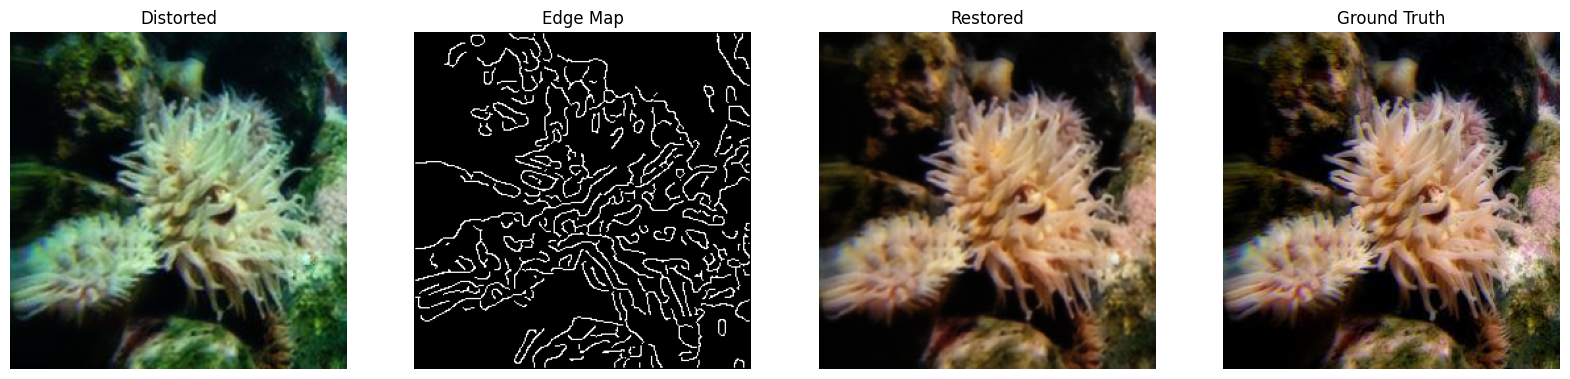

In [14]:
#8 visualization
generator.eval()
with torch.no_grad():
    distorted, ground_truth = next(iter(train_loader))
    distorted, ground_truth = distorted.to(device), ground_truth.to(device)
    fake = generator(distorted)  # Single output: [batch_size, 3, 256, 256]
    
    # Extract first image from batch and convert to NumPy
    distorted_np = distorted[0, :3].cpu().numpy().transpose(1, 2, 0)  # [3, 256, 256] -> [256, 256, 3]
    ground_truth_np = ground_truth[0].cpu().numpy().transpose(1, 2, 0)  # [3, 256, 256] -> [256, 256, 3]
    fake_np = fake[0].cpu().numpy().transpose(1, 2, 0)  # [3, 256, 256] -> [256, 256, 3]
    edge_np = distorted[0, 3].cpu().numpy()  # [256, 256] (edge map)
    
    # Plot
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow((distorted_np + 1) / 2); axs[0].set_title("Distorted")
    axs[1].imshow(edge_np, cmap='gray'); axs[1].set_title("Edge Map")
    axs[2].imshow((fake_np + 1) / 2); axs[2].set_title("Restored")
    axs[3].imshow((ground_truth_np + 1) / 2); axs[3].set_title("Ground Truth")
    for ax in axs:
        ax.axis('off')
    plt.show()